In [64]:
import sys, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random


In [65]:
sys.path.append(
    "/Users/wiegerscheurer/repos/physicspred"
)  # To enable importing from repository folders


from functions.utilities import ordinal_sample, bellshape_sample
from functions.physics import _rotate_90, _dir_to_vec, _vec_to_dir, _flip_dir
from functions.utilities import check_balance, create_balanced_trial_design, build_design_matrix, determine_sequence
from functions.analysis import (get_precision, 
                                get_data, 
                                get_false_negatives,
                                get_false_positives,
                                get_true_positives,
                                get_true_negatives,
                                filter_condition,
                                get_f1_score, 
                                get_rt, 
                                get_accuracy,
                                get_hit_rate,)


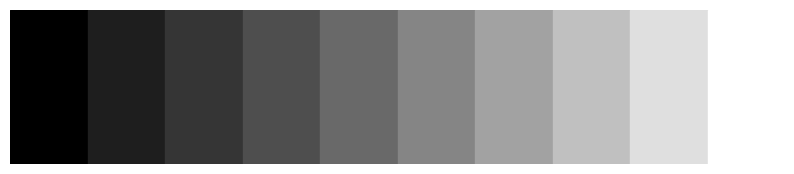

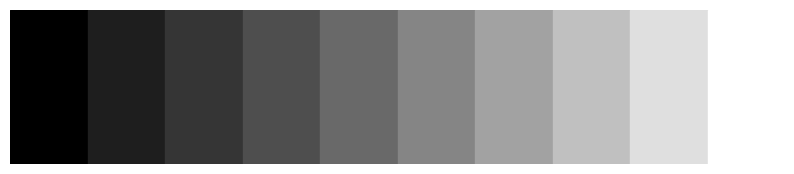

In [855]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

def weber_contrast(luminance, background_luminance):
    return (luminance - background_luminance) / background_luminance

def create_perceptual_luminance_series(start_lab, end_lab, steps):
    start_rgb = color.lab2rgb(np.array([[start_lab]], dtype=np.float32))[0][0]
    end_rgb = color.lab2rgb(np.array([[end_lab]], dtype=np.float32))[0][0]
    
    start_luminance = color.rgb2lab(np.array([[start_rgb]], dtype=np.float32))[0][0][0]
    end_luminance = color.rgb2lab(np.array([[end_rgb]], dtype=np.float32))[0][0][0]
    
    luminance_series = np.linspace(start_luminance, end_luminance, steps)
    lab_series = np.array([[luminance, 0, 0] for luminance in luminance_series], dtype=np.float32)
    rgb_series = color.lab2rgb(lab_series)
    
    return rgb_series

def plot_gradient(start_lab, end_lab, steps, background_luminance):
    gradient = create_perceptual_luminance_series(start_lab, end_lab, steps)
    
    fig, ax = plt.subplots(figsize=(10, 2))
    for i, rgb in enumerate(gradient):
        contrast = weber_contrast(color.rgb2lab(np.array([[rgb]], dtype=np.float32))[0][0][0], background_luminance)
        ax.add_patch(plt.Rectangle((i / steps, 0), 1 / steps, 1, color=rgb, label=f'Contrast: {contrast:.2f}'))
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

# Example usage
background_luminance = 0  # Example background luminance
start_lab = [0, 0, 0]  # Black in CIELAB
end_lab = [100, 0, 0]  # White in CIELAB
steps = 10

plot_gradient(start_lab, end_lab, steps, 100)
plot_gradient(start_lab, end_lab, steps, 1)

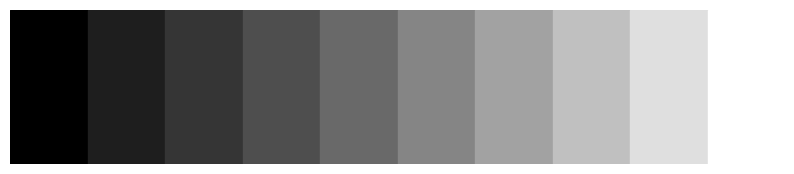

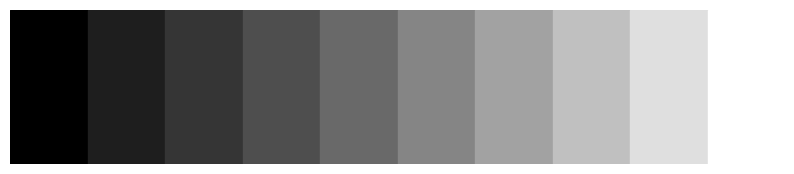

In [858]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

def michelson_contrast(luminance1, luminance2):
    return (luminance1 - luminance2) / (luminance1 + luminance2)

def create_perceptual_luminance_series(start_lab, end_lab, steps):
    start_rgb = color.lab2rgb(np.array([[start_lab]], dtype=np.float32))[0][0]
    end_rgb = color.lab2rgb(np.array([[end_lab]], dtype=np.float32))[0][0]
    
    start_luminance = color.rgb2lab(np.array([[start_rgb]], dtype=np.float32))[0][0][0]
    end_luminance = color.rgb2lab(np.array([[end_rgb]], dtype=np.float32))[0][0][0]
    
    luminance_series = np.linspace(start_luminance, end_luminance, steps)
    lab_series = np.array([[luminance, 0, 0] for luminance in luminance_series], dtype=np.float32)
    rgb_series = color.lab2rgb(lab_series)
    
    return rgb_series

def plot_gradient(start_lab, end_lab, steps, background_luminance):
    gradient = create_perceptual_luminance_series(start_lab, end_lab, steps)
    
    fig, ax = plt.subplots(figsize=(10, 2))
    for i, rgb in enumerate(gradient):
        luminance = color.rgb2lab(np.array([[rgb]], dtype=np.float32))[0][0][0]
        contrast = michelson_contrast(luminance, background_luminance)
        ax.add_patch(plt.Rectangle((i / steps, 0), 1 / steps, 1, color=rgb, label=f'Contrast: {contrast:.2f}'))
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

# Example usage
background_luminance = 50  # Example background luminance
start_lab = [0, 0, 0]  # Black in CIELAB
end_lab = [100, 0, 0]  # White in CIELAB
steps = 10

plot_gradient(start_lab, end_lab, steps, 100)
plot_gradient(start_lab, end_lab, steps, 1)

### Tsjebyshev

In [643]:
ci = filter_condition(testdf, True, False)
ic = filter_condition(testdf, False, True)

ic

,trial_type,trial,ball_speed,ball_start_color,ball_color_change,interactor,bounce,bounce_moment,random_bounce_direction,target_onset,...,start_pos,end_pos,abs_rfup,abs_rfright,abs_rfdown,abs_rfleft,sim_rfup,sim_rfright,sim_rfdown,sim_rfleft
1,interactor,2,9.524951,-0.059920,0.335,45_top_u,False,NaN,NaN,3.857237,...,down,up,"(1, 1)","(0, 0)","(0, 0)","(0, 0)","(0, 1)","(0, 0)","(0, 0)","(1, 0)"
8,interactor,9,9.305617,0.205997,-0.168,45_bottom_l,False,NaN,NaN,3.867418,...,right,left,"(0, 0)","(0, 0)","(0, 0)","(1, 1)","(1, 0)","(0, 0)","(0, 0)","(0, 1)"
11,interactor,12,9.505664,0.169009,0.335,135_bottom_r,False,NaN,NaN,3.867552,...,left,right,"(0, 0)","(1, 1)","(0, 0)","(0, 0)","(1, 0)","(0, 1)","(0, 0)","(0, 0)"
14,interactor,15,9.470612,-0.053485,0.168,45_bottom_l,False,NaN,NaN,3.864875,...,right,left,"(0, 0)","(0, 0)","(0, 0)","(1, 1)","(1, 0)","(0, 0)","(0, 0)","(0, 1)"
17,interactor,18,9.164379,0.296534,-0.168,45_top_r,False,NaN,NaN,3.865951,...,left,right,"(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)","(0, 1)","(1, 0)","(0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,interactor,379,9.139883,0.302358,0.335,45_top_r,False,NaN,NaN,3.856808,...,left,right,"(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)","(0, 1)","(1, 0)","(0, 0)"
1394,interactor,395,8.936522,0.082162,0.335,45_bottom_l,False,NaN,NaN,3.857682,...,right,left,"(0, 0)","(0, 0)","(0, 0)","(1, 1)","(1, 0)","(0, 0)","(0, 0)","(0, 1)"
1396,interactor,397,9.562510,0.022030,0.000,135_bottom_d,False,NaN,NaN,3.857134,...,up,down,"(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)","(0, 1)","(1, 0)"
1398,interactor,399,9.037591,0.284856,-0.168,45_bottom_l,False,NaN,NaN,3.857377,...,right,left,"(0, 0)","(0, 0)","(0, 0)","(1, 1)","(1, 0)","(0, 0)","(0, 0)","(0, 1)"


In [ ]:
# all_sub_names = ["002634"]
sub_stack = pd.DataFrame()

# for sub_idx, sub in enumerate(all_sub_names):
    this_sub = get_data(subject=f"sub-{sub}", task="ball_hue")
    sub_stack = pd.concat([sub_stack, this_sub])
    
sub_stack.reset_index(inplace=True, drop=True)
# sub_stack

In [8]:
sub_stack = pd.DataFrame()


sub_stack = get_data(subject=None, task="ball_hue")
    # sub_stack = pd.concat([sub_stack, this_sub])

# sub_stack.reset_index(inplace=True, drop=True)


In [832]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.polynomial.polynomial import polyfit, polyval
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit


def logistic_function(x, L, x0, k, b):
    """
    Standard logistic function with parameters:
    L: the curve's maximum value (typically 1 for probability)
    x0: the x-value of the sigmoid's midpoint
    k: the steepness of the curve
    b: the minimum value (typically 0 for probability)
    """
    return L / (1 + np.exp(-k * (x - x0))) + b
        
# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b)**2) / (2 * c**2))

def weibull_cdf(x, lamb, beta):
    return 1 - np.exp(-(x / lamb) ** beta)

def create_psychometric_plots(data, title=None, prob_ylim=None, rt_ylim=None, 
                              prob_poly_fit=None, rt_poly_fit=None, rt_gaussian_fit=None, split_hypotheses=False,
                              save_fig:bool=False, cmap:str="gist_earth", line_alpha:float=.4, fit_alpha:float=.9,
                              prob_type:str="o-", rt_type:str="o-", fit_type:str="--",
                              rt_correct_only:bool=False, fit_width:float=8.5, line_width:float=3.5):
    """
    Create two psychometric plots with customizable features.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing the columns 'ball_color_change', 'response', and 'rt'
    title : str, optional
        Custom title for the overall figure
    prob_ylim : tuple, optional
        Custom y-axis range for probability plot (min, max)
    rt_ylim : tuple, optional
        Custom y-axis range for reaction time plot (min, max)
    prob_poly_fit : int or None, optional
        Use sigmoid fit for probability data (if not None)
    rt_poly_fit : int or None, optional
        Degree of polynomial to fit to reaction time data (None for no fit)
    split_hypotheses : bool, optional
        Whether to split the data into four hypotheses using filter_condition
    """
    # Ensure polynomial degrees are integers
    if rt_poly_fit is not None:
        rt_poly_fit = int(rt_poly_fit)
    
    color_spectrum = plt.get_cmap(cmap)

    hypotheses = ['CC', 'CI', 'IC', 'II']

    # Normalize the indices to map them to the colormap
    norm = mcolors.Normalize(vmin=0, vmax=len(hypotheses) - 1)
        
    # Figure setup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    plt.tight_layout(pad=4)
    
    if not split_hypotheses:
        # Original implementation for a single dataset
        # Extract unique values of ball_color_change and ensure they are in order
        color_changes = sorted(data['ball_color_change'].unique())
        
        # Convert color changes to numeric for fitting
        x_numeric = np.array([float(x) for x in color_changes])
        
        # Calculate probability of "lighter" response for each ball_color_change value
        prob_lighter = []
        for change in color_changes:
            subset = data[data['ball_color_change'] == change]
            prob = (subset['response'] == 'lighter').mean()
            prob_lighter.append(prob)
        
        # Calculate mean reaction time for each ball_color_change value
        mean_rt = []
        rt_error = []  # for standard error
        for change in color_changes:
            subset = data[data['ball_color_change'] == change]
            mean_rt.append(subset['rt'].mean())
            rt_error.append(subset['rt'].std() / np.sqrt(len(subset)))
        
        # Plot 1: Probability of "lighter" response
        ax1.plot(color_changes, prob_lighter, 'o-', color='blue', markersize=8, label='Data')
        
        # Add sigmoid fit if requested
        if prob_poly_fit is not None and len(color_changes) > 3:  # Need at least 4 points for a reliable sigmoid
            try:
                # Initial parameter guesses: L=1, x0=midpoint, k=1, b=0
                p0 = [1, np.median(x_numeric), 1, 0]
                
                # Bounds to constrain parameters to reasonable values
                # L between 0.9 and 1.1, x0 within range, k positive, b between -0.1 and 0.1
                bounds = ([0.9, min(x_numeric), 0.001, -0.1], 
                          [1.1, max(x_numeric), 10, 0.1])
                
                # Fit the sigmoid function to the data
                params, _ = curve_fit(logistic_function, x_numeric, prob_lighter, 
                                     p0=p0, bounds=bounds, maxfev=10000)
                
                # Create a more fine-grained x for smooth curve
                x_fit = np.linspace(min(x_numeric), max(x_numeric), 100)
                y_fit = logistic_function(x_fit, *params)
                
                # Extract parameters for labeling
                L, x0, k, b = params
                
                # Plot fitted curve
                ax1.plot(x_fit, y_fit, 'r--', linewidth=2, 
                         label=f'Sigmoid fit\nMidpoint: {x0:.2f}, Slope: {k:.2f}')
            except Exception as e:
                print(f"Error fitting sigmoid: {e}")
        
        # Plot 2: Reaction time
        ax2.errorbar(color_changes, mean_rt, yerr=rt_error, fmt='o-', color='green', 
                    markersize=8, capsize=5, label='Data')
        
        # Add polynomial fit if requested for RT data
        if rt_poly_fit is not None and len(color_changes) > rt_poly_fit:
            try:
                # Fit polynomial of specified degree
                coefs = polyfit(x_numeric, mean_rt, rt_poly_fit)
                
                # Create a more fine-grained x for smooth curve
                x_fit = np.linspace(min(x_numeric), max(x_numeric), 100)
                y_fit = polyval(x_fit, coefs)
                
                # Plot fitted curve
                ax2.plot(x_fit, y_fit, 'r--', linewidth=2, 
                         label=f'{rt_poly_fit}-degree polynomial fit')
            except Exception as e:
                print(f"Error fitting RT polynomial: {e}")
        
        # Add labels for number of trials per condition
        for i, change in enumerate(color_changes):
            count = len(data[data['ball_color_change'] == change])
            ax1.annotate(f'n={count}', xy=(change, prob_lighter[i]), 
                        xytext=(0, 10), textcoords='offset points', 
                        ha='center', va='bottom', fontsize=8)
    
    else:
        # Implementation for split hypotheses
                    
        # Get data for each hypothesis
        cc = filter_condition(data, True, True)
        ci = filter_condition(data, True, False)
        ic = filter_condition(data, False, True)
        ii = filter_condition(data, False, False)
        
        # Define colors and labels for each hypothesis
        hypotheses = [
            (cc, 'SC_EC', color_spectrum(norm(0))),
            (ci, 'SC_EI', color_spectrum(norm(1))),
            (ic, 'SI_EC', color_spectrum(norm(2))),
            (ii, 'SI_EI', color_spectrum(norm(3)))
        ]
        
        # Find the common set of color changes across all hypotheses
        all_changes = set()
        for hyp_data, _, _ in hypotheses:
            all_changes.update(hyp_data['ball_color_change'].unique())
        color_changes = sorted(all_changes)
        
        # Plot for each hypothesis
        for hyp_data, label, color in hypotheses:
            hyp_color_changes = sorted(hyp_data['ball_color_change'].unique())
            
            # Skip if no data for this hypothesis
            if len(hyp_color_changes) == 0:
                continue
                
            # Convert to numeric values for fitting
            hyp_x_numeric = np.array([float(x) for x in hyp_color_changes])
            
            # Calculate probability of "lighter" response
            prob_lighter = []
            for change in hyp_color_changes:
                subset = hyp_data[hyp_data['ball_color_change'] == change]
                if len(subset) > 0:
                    prob = (subset['response'] == 'lighter').mean()
                    prob_lighter.append(prob)
                else:
                    prob_lighter.append(np.nan)
            
            # Calculate mean reaction time and error
            mean_rt = []
            rt_error = []
            for change in hyp_color_changes:
                subset = hyp_data[hyp_data['ball_color_change'] == change]
                if len(subset) > 0:
                    mean_rt.append(subset['rt'].mean())
                    rt_error.append(subset['rt'].std() / np.sqrt(len(subset)))
                else:
                    mean_rt.append(np.nan)
                    rt_error.append(np.nan)
            
            # Convert lists to numpy arrays for easier manipulation
            prob_lighter_array = np.array(prob_lighter)
            mean_rt_array = np.array(mean_rt)
            
            # Plot probability data
            ax1.plot(hyp_color_changes, prob_lighter, prob_type, color=color, 
                    markersize=6, label=f'Trialtype {label}', alpha=line_alpha, linewidth=line_width)
            
            # Add sigmoid fit if requested
            if prob_poly_fit is not None:
                # Check if we have enough valid data points for fitting
                valid_indices = ~np.isnan(prob_lighter_array)
                num_valid = np.sum(valid_indices)
                
                if num_valid > 3:  # Need at least 4 points for reliable sigmoid
                    try:
                        # Extract valid x and y values
                        valid_x = hyp_x_numeric[valid_indices]
                        valid_y = prob_lighter_array[valid_indices]
                        
                        # Initial parameter guesses
                        p0 = [1, np.median(valid_x), 1, 0]
                        
                        # Bounds to constrain parameters
                        bounds = ([0.9, min(valid_x), 0.001, -0.1], 
                                  [1.1, max(valid_x), 10, 0.1])
                        
                        # Fit sigmoid function
                        params, _ = curve_fit(logistic_function, valid_x, valid_y, 
                                             p0=p0, bounds=bounds, maxfev=10000)
                        
                        # Create a more fine-grained x for smooth curve within the VALID range
                        x_fit = np.linspace(min(valid_x), max(valid_x), 100)
                        y_fit = logistic_function(x_fit, *params)
                        
                        # Extract parameters for labeling
                        L, x0, k, b = params
                        
                        # Plot fitted curve
                        ax1.plot(x_fit, y_fit, fit_type, color=color, linewidth=fit_width, 
                                alpha=fit_alpha, label=f'Slope: {k:.2f}\nMidpoint: {x0:.2f}')
                    except Exception as e:
                        print(f"Error fitting sigmoid for {label}: {e}")
                        print(f"Debug - valid_x shape: {valid_x.shape}, valid_y shape: {valid_y.shape}")
            
            # # Plot reaction time data
            # ax2.errorbar(hyp_color_changes, mean_rt, yerr=rt_error, fmt=rt_type, 
            #             color=color, markersize=6, capsize=4, 
            #             label=f'Condition {label}', alpha=line_alpha, linewidth=line_width)
            
            ax2.errorbar(hyp_color_changes, mean_rt, yerr=rt_error, fmt=rt_type, 
                        color=color, markersize=8, capsize=5, capthick=2, elinewidth=1.5,
                        markerfacecolor='white', markeredgewidth=2,
                        label=f'Trialtype {label}', alpha=line_alpha, linewidth=line_width)

            
            if rt_gaussian_fit:  # Replace rt_poly_fit with a boolean flag for Gaussian fit
                # Check if we have enough valid data points for fitting
                valid_indices = ~np.isnan(mean_rt_array)
                num_valid = np.sum(valid_indices)
                
                if num_valid > 3:  # Gaussian fit requires at least 3 points
                    try:
                        # Extract valid x and y values
                        valid_x = hyp_x_numeric[valid_indices]
                        valid_y = mean_rt_array[valid_indices]
                        
                        # Initial guess for parameters (a, b, c)
                        p0 = [np.max(valid_y), np.mean(valid_x), np.std(valid_x)]
                        
                        # Fit Gaussian function
                        popt, _ = curve_fit(gaussian, valid_x, valid_y, p0=p0)
                        
                        # Create a more fine-grained x for smooth curve within the VALID range
                        x_fit = np.linspace(min(valid_x), max(valid_x), 100)
                        y_fit = gaussian(x_fit, *popt)
                        
                        
                        # Plot fitted curve
                        ax2.plot(x_fit, y_fit, fit_type, color=color, linewidth=fit_width,
                                alpha=fit_alpha, label=f'Gaussian fit')
                        
                    except Exception as e:
                        print(f"Error in gaussian fitting: {e}")
                        
            if rt_poly_fit:  # Replace rt_poly_fit with a boolean flag for polynomial fit
                # Check if we have enough valid data points for fitting
                valid_indices = ~np.isnan(mean_rt_array)
                num_valid = np.sum(valid_indices)
                
                if num_valid > 3:  # Polynomial fit requires at least 3 points
                    try:
                        # Extract valid x and y values
                        valid_x = hyp_x_numeric[valid_indices]
                        valid_y = mean_rt_array[valid_indices]
                        
                        # Degree of the polynomial
                        degree = rt_poly_fit  # You can change this to the desired polynomial degree
                        
                        # Fit polynomial function
                        p = np.polyfit(valid_x, valid_y, degree)
                        poly = np.poly1d(p)
                        
                        # Create a more fine-grained x for smooth curve within the VALID range
                        x_fit = np.linspace(min(valid_x), max(valid_x), 100)
                        y_fit = poly(x_fit)
                        
                        # Plot fitted curve
                        ax2.plot(x_fit, y_fit, fit_type, color=color, linewidth=fit_width,
                                alpha=fit_alpha, label=f'{degree}deg polynom fit')
                    except Exception as e:
                        print(f"Error in polynomial fitting: {e}")

    # Common settings for both plots
    ax1.set_xlabel('Ball Luminance Change')
    ax1.set_ylabel('Probability of "Lighter" Response')
    ax1.set_title('Psychometric Function: Probability of "Lighter" Response')
    
    # Set custom y-axis limits if provided
    if prob_ylim:
        ax1.set_ylim(prob_ylim)
    else:
        ax1.set_ylim(0, 1)  # Default range for probability
    
    # ax1.grid(True, alpha=0.2)
    ax1.yaxis.grid(True, alpha=.25)
    ax1.legend(loc='best')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_xticks([-0.3, -.15, 0, .15, .3])
    
    # Add horizontal line at 0.5 probability for reference
    ax1.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
    
    ax2.set_xlabel('Ball Luminance Change')
    ax2.set_ylabel('Reaction Time (s)')
    ax2.set_title('Reaction Time by Ball Lumin Change')
    
    # Set custom y-axis limits if provided
    if rt_ylim:
        ax2.set_ylim(rt_ylim)
    
    # ax2.grid(True, alpha=0.1)
    ax2.yaxis.grid(True, alpha=.25)
    ax2.legend(loc='best')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xticks([-0.3, -.15, 0, .15, .3])

    # Set custom title if provided
    if title:
        plt.suptitle(title, fontsize=16)
    else:
        plt.suptitle('Psychometric Analysis of Ball Hue Task', fontsize=16)
    
    if save_fig:
        plt.savefig('psychometric_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

In [807]:
testdf = get_data(subject="sub-527524", task="ball_hue") # mingyao, gok ik

lights = testdf["response"] == "lighter"
darks = testdf["response"] == "darker"

total_responses = (np.sum(lights) + np.sum(darks))

print(f"{total_responses} of which {np.sum(lights)} lighter and {np.sum(darks)} darker")
# np.sum(lights)

# np.sum(darks)

387 of which 191 lighter and 196 darker


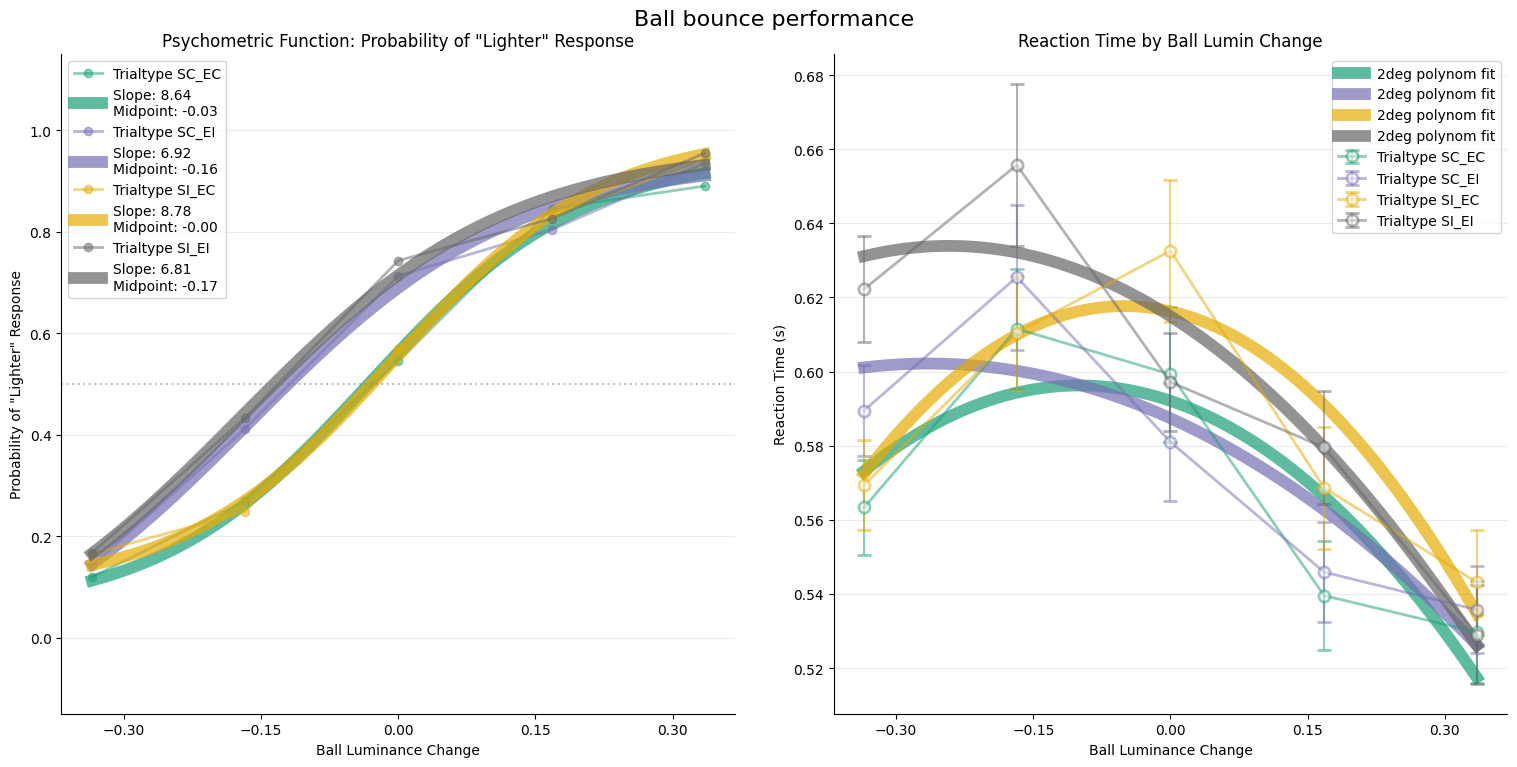

0.6654411764705882
0.6261510128913443
0.6703703703703704
0.638733705772812


In [833]:
import cmocean
import colormaps as cmaps





# all_sub_names = ["653250", "303045", "189554", "893176", "418891"]
all_sub_names = ["303045", "189554", "893176", "418891"]
sub_stack = pd.DataFrame()

for sub_idx, sub in enumerate(all_sub_names):
    this_sub = get_data(subject=f"sub-{sub}", task="ball_hue")
    sub_stack = pd.concat([sub_stack, this_sub])
    
sub_stack.reset_index(inplace=True, drop=True)
# sub_stack

# testdf = get_data(subject="sub-323481", task="ball_hue") # This one is faulty, because of the feedback freq, many times no answer was given

# ii = filter_condition(testdf, False, False)
# testdf = get_data(subject="sub-653250", task="ball_hue") # dit ben ik? (112 lighter, 88 darker)
# testdf = get_data(subject="sub-189554", task="ball_hue") # melvin, denk ik? (248 lighter, 146 darker) buttonreverse
# testdf = get_data(subject="sub-303045", task="ball_hue") # mingyao, gok ik (180 lighter, 218 darker)
# testdf = get_data(subject="sub-893176", task="ball_hue") # wenshu, 247 lighter, 138 darker
# testdf = get_data(subject="sub-418891", task="ball_hue") # bilge, 278 lighter, 122 darker
# testdf = get_data(subject="sub-527524", task="ball_hue") # yifan, 191 lighter, 196 darker
# testdf = sub_stack

testdf = get_data(subject=None, task="ball_hue")
testdf = testdf[(testdf["response"] == "lighter") | (testdf["response"] == "darker")] # Only take valid responses

# testdf_correct = testdf[testdf["accuracy"] == True]

_ = create_psychometric_plots(data=testdf, 
                              title="Ball bounce performance", 
                              prob_ylim=(-.15, 1.15), 
                              # prob_ylim=(.05 ,1), 
                            #   rt_ylim=(0.45, 1), 
                              prob_poly_fit=True, 
                              # rt_gaussian_fit=1,
                              rt_poly_fit=2,
                              split_hypotheses=True,
                              cmap=cmaps.dark2,
                              line_alpha = .5,
                              fit_alpha = .7,
                              prob_type = "o-",
                              rt_type = "-o",
                              fit_type = "-",
                              fit_width = 8.5,
                              line_width = 2,
                              )

cc = filter_condition(testdf, True, True)
ci = filter_condition(testdf, True, False)
ic = filter_condition(testdf, False, True)
ii = filter_condition(testdf, False, False)

print(np.sum(cc["accuracy"] == True) / len(cc["accuracy"]))
print(np.sum(ci["accuracy"] == True) / len(ci["accuracy"]))
print(np.sum(ic["accuracy"] == True) / len(ic["accuracy"]))
print(np.sum(ii["accuracy"] == True) / len(ii["accuracy"]))


In [809]:
testdf

,trial_type,trial,ball_speed,ball_start_color,ball_color_change,interactor,bounce,bounce_moment,random_bounce_direction,target_onset,...,start_pos,end_pos,abs_rfup,abs_rfright,abs_rfdown,abs_rfleft,sim_rfup,sim_rfright,sim_rfdown,sim_rfleft
0,empty,1,9.433553,-0.332641,-0.168,none_l,False,NaN,NaN,3.894557,...,right,left,"(0, 0)","(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)"
1,interactor,2,9.927460,0.386071,0.168,135_bottom_d,True,3.582266,NaN,3.867072,...,up,left,"(0, 0)","(0, 0)","(1, 0)","(0, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)"
2,interactor,3,9.658047,0.003234,0.168,135_bottom_d,False,NaN,NaN,3.857871,...,up,down,"(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)","(0, 1)","(1, 0)"
3,empty,4,9.606193,0.269103,0.000,none_d,True,3.574747,right,3.841310,...,up,left,"(0, 0)","(0, 0)","(1, 0)","(0, 1)","(0, 0)","(0, 0)","(1, 0)","(0, 1)"
4,empty,5,9.755566,0.341945,0.335,none_u,False,NaN,NaN,3.858602,...,down,up,"(1, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,empty,396,9.570566,0.470220,-0.335,none_d,False,NaN,NaN,3.858789,...,up,down,"(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)","(0, 0)"
2196,empty,397,9.706750,0.159849,0.000,none_l,True,3.573719,right,3.840602,...,right,up,"(0, 1)","(0, 0)","(0, 0)","(1, 0)","(0, 1)","(0, 0)","(0, 0)","(1, 0)"
2197,empty,398,9.633353,-0.067869,-0.168,none_l,True,3.575041,right,3.840748,...,right,up,"(0, 1)","(0, 0)","(0, 0)","(1, 0)","(0, 1)","(0, 0)","(0, 0)","(1, 0)"
2198,empty,399,9.620301,0.054362,0.000,none_d,False,NaN,NaN,3.858162,...,up,down,"(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)","(0, 0)"


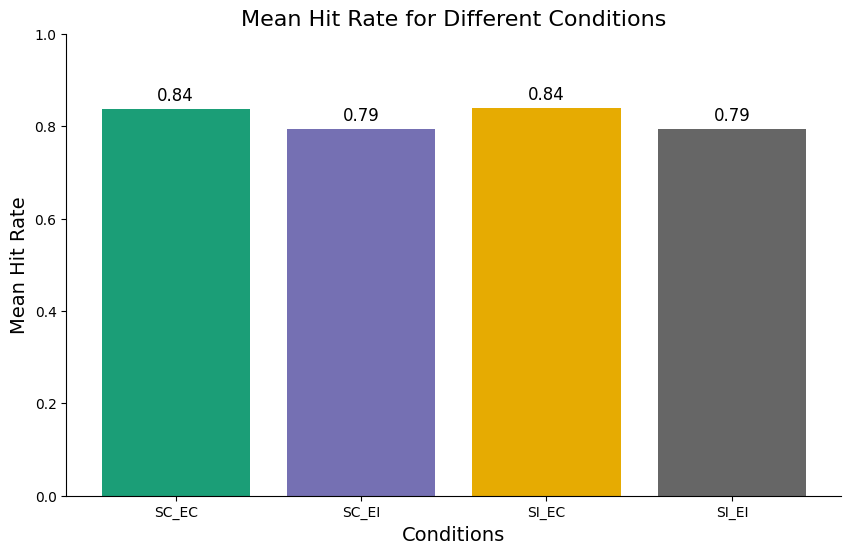

In [835]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming get_data and filter_condition functions are defined
testdf = get_data(subject=None, task="ball_hue")
testdf = testdf[(testdf["response"] == "lighter") | (testdf["response"] == "darker")] # Only take valid responses

cc = filter_condition(testdf, True, True)
ci = filter_condition(testdf, True, False)
ic = filter_condition(testdf, False, True)
ii = filter_condition(testdf, False, False)

# Calculate mean accuracy values
mean_accuracy_cc = cc["accuracy"].mean()
mean_accuracy_ci = ci["accuracy"].mean()
mean_accuracy_ic = ic["accuracy"].mean()
mean_accuracy_ii = ii["accuracy"].mean()

# Create a list of mean accuracy values for each condition
mean_accuracy_values = [mean_accuracy_cc, mean_accuracy_ci, mean_accuracy_ic, mean_accuracy_ii]
hypotheses = ['SC_EC', 'SC_EI', 'SI_EC', 'SI_EI']

color_spectrum = plt.get_cmap('Dark2')
norm = mcolors.Normalize(vmin=0, vmax=len(hypotheses) - 1)

colors = [color_spectrum(norm(col_no)) for col_no in range(len(hypotheses))]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(hypotheses, mean_accuracy_values, color=colors)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Customize the plot
plt.title('Mean Hit Rate for Different Conditions', fontsize=16)
plt.xlabel('Conditions', fontsize=14)
plt.ylabel('Mean Hit Rate', fontsize=14)
plt.ylim(0, 1)  # Since accuracy is a proportion, the y-axis should be between 0 and 1

# Remove the top and right spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the plot
plt.show()

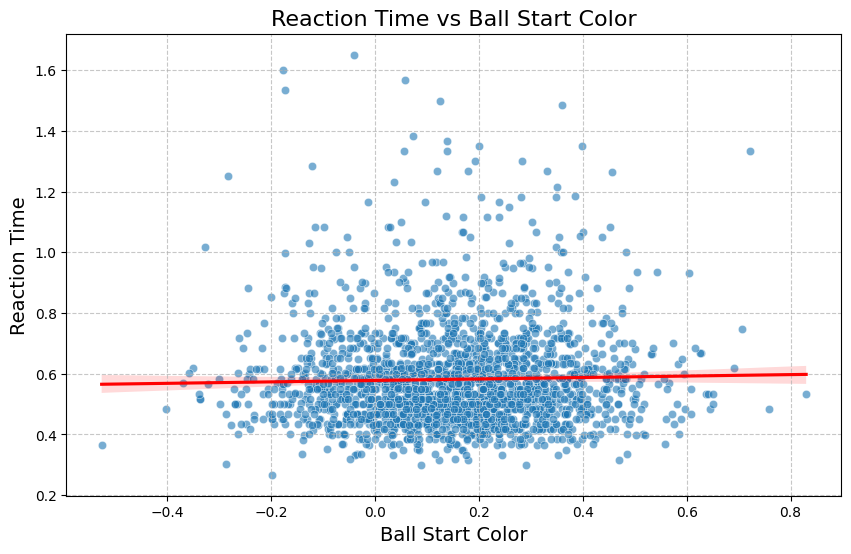

In [811]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming get_data function is defined
testdf = get_data(subject=None, task="ball_hue")

# Extract the relevant columns
reaction_time = testdf["rt"]
ball_start_color = testdf["ball_start_color"]

# Create a scatter plot with a trend line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ball_start_color, y=reaction_time, alpha=0.6)
sns.regplot(x=ball_start_color, y=reaction_time, scatter=False, color='red')

# Customize the plot
plt.title('Reaction Time vs Ball Start Color', fontsize=16)
plt.xlabel('Ball Start Color', fontsize=14)
plt.ylabel('Reaction Time', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

/var/folders/3n/yy1xjnlj5zd3nt4r1202183h0000gn/T/ipykernel_32284/1990220999.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = testdf.groupby(bins)["rt"].mean().reset_index()


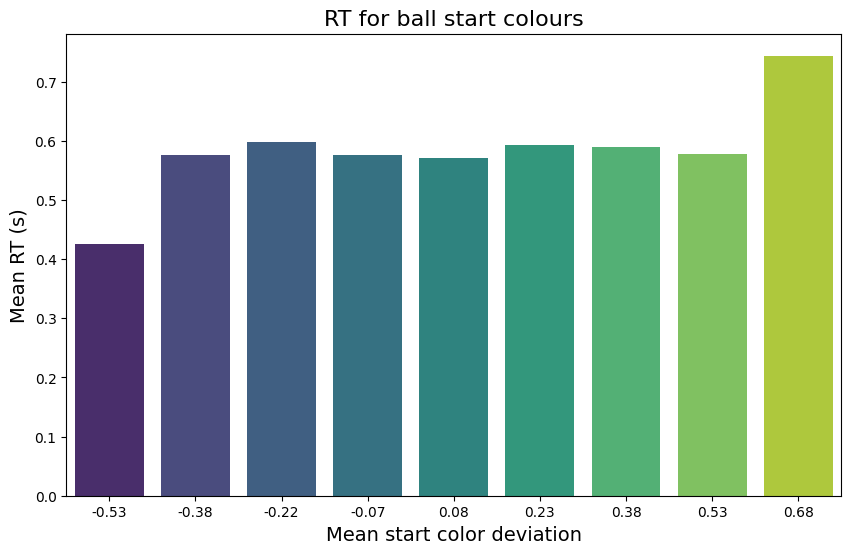

In [812]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming get_data function is defined
testdf = get_data(subject=None, task="ball_hue")

# Extract the relevant columns
reaction_time = testdf["rt"]
ball_start_color = testdf["ball_start_color"]
bins = 9
labels = np.arange(np.min(ball_start_color), np.max(ball_start_color), step=(np.max(ball_start_color) - np.min(ball_start_color)) / bins)

# round each label to 2 decimals
labels = np.round(labels, 2)

# Bin the ball_start_color into 5 bins
bins = pd.cut(ball_start_color, bins=bins, labels=labels)

# Calculate the mean reaction time for each bin
binned_data = testdf.groupby(bins)["rt"].mean().reset_index()
binned_data.columns = ['Ball Start Color Bin', 'Mean Reaction Time']

# Create a bar plot for the mean reaction time per bin
plt.figure(figsize=(10, 6))
sns.barplot(x='Ball Start Color Bin', y='Mean Reaction Time', data=binned_data, palette='viridis', hue="Ball Start Color Bin", legend=False)

# Customize the plot
plt.title('RT for ball start colours', fontsize=16)
plt.xlabel('Mean start color deviation', fontsize=14)
plt.ylabel('Mean RT (s)', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

/var/folders/3n/yy1xjnlj5zd3nt4r1202183h0000gn/T/ipykernel_32284/2252021463.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = testdf.groupby(bins)["accuracy"].mean().reset_index()


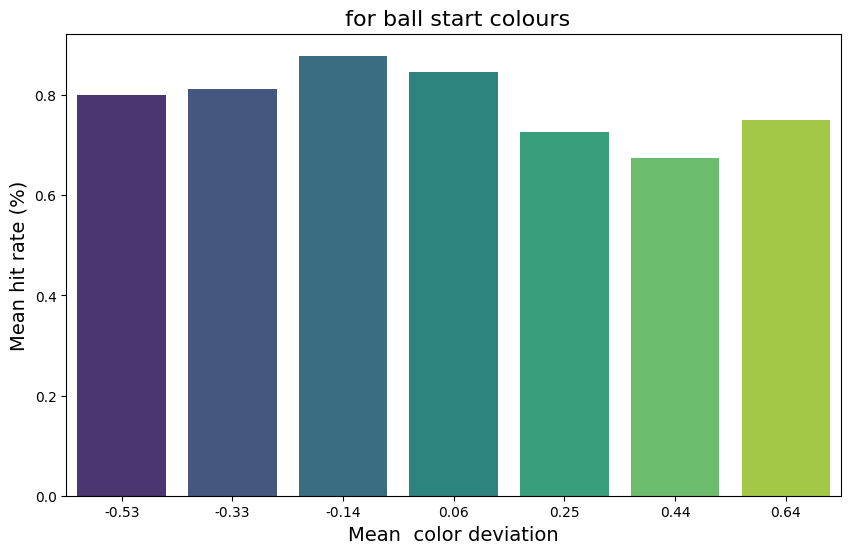

In [825]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming get_data function is defined
testdf = get_data(subject=None, task="ball_hue")

# Extract the relevant columns
reaction_time = testdf["rt"]
ball_start_color = testdf["ball_start_color"]
bins = 7
labels = np.arange(np.min(ball_start_color), np.max(ball_start_color), step=(np.max(ball_start_color) - np.min(ball_start_color)) / bins)

# round each label to 2 decimals
labels = np.round(labels, 2)

# Bin the ball_start_color into 5 bins
bins = pd.cut(ball_start_color, bins=bins, labels=labels)

# Calculate the mean reaction time for each bin
# binned_data = testdf.groupby(bins)["rt"].mean().reset_index()
testdf = testdf[(testdf["response"] == "lighter") | (testdf["response"] == "darker")] # Only take valid responses
binned_data = testdf.groupby(bins)["accuracy"].mean().reset_index()
# binned_data = get_hit_rate((testdf.groupby(bins)["accuracy"]), True, True)
# binned_data = testdf.groupby(bins)

binned_data.columns = ['Ball Start Color Bin', 'Mean Reaction Time']

# Create a bar plot for the mean reaction time per bin
plt.figure(figsize=(10, 6))
sns.barplot(x='Ball Start Color Bin', y='Mean Reaction Time', data=binned_data, palette='viridis', hue="Ball Start Color Bin", legend=False)

# Customize the plot
plt.title(' for ball start colours', fontsize=16)
plt.xlabel('Mean  color deviation', fontsize=14)
plt.ylabel('Mean hit rate (%)', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [824]:
# testdf = testdf[testdf["response"] == "lighter" or testdf["response"] == "darker"]
testdf = testdf[(testdf["response"] == "lighter") | (testdf["response"] == "darker")]
testdf["response"].unique()

array(['lighter', 'darker'], dtype=object)

In [792]:
binned_data["accuracy"].mean()

ball_start_color
-0.53         0.8
-0.33    0.818182
-0.14    0.882857
0.06     0.830065
0.25      0.70679
0.44     0.648148
0.64     0.714286
Name: accuracy, dtype: object

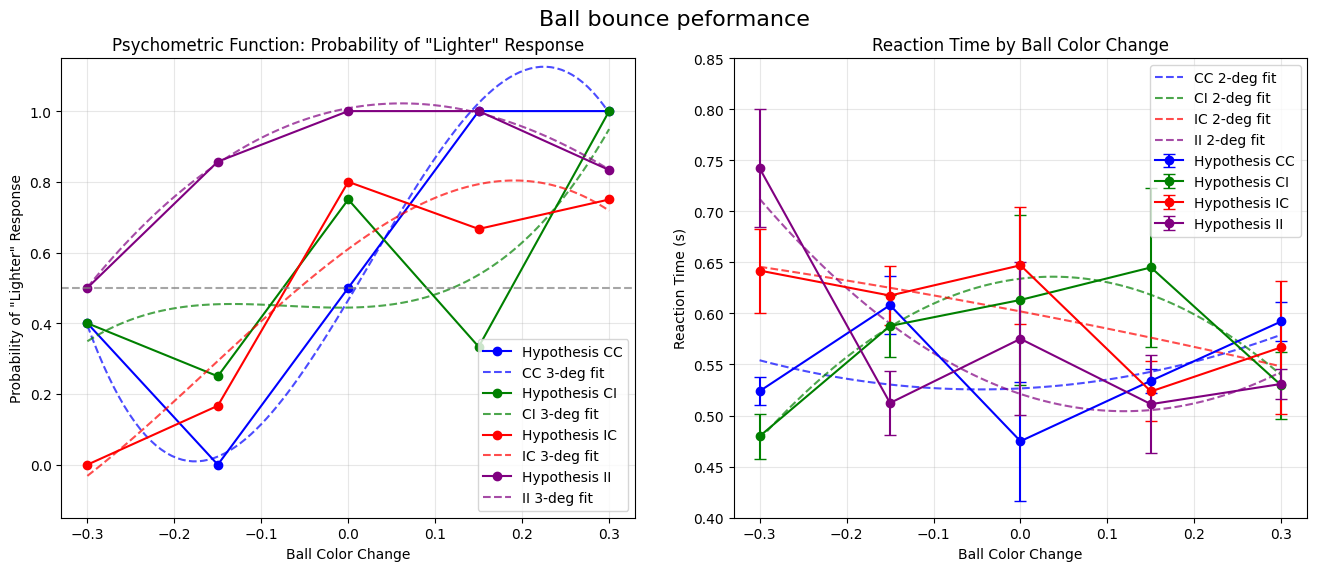

In [115]:

testdf = get_data(subject=None, task="ball_hue")
# ii = filter_condition(testdf, False, False)

# testdf = get_data(subject="incomplete/sub-927320", task="ball_hue")
_ = create_psychometric_plots(data=testdf, 
                              title="Ball bounce peformance", 
                              prob_ylim=(-.15, 1.15), 
                              rt_ylim=(0.4, .85), 
                              prob_poly_fit=3, 
                              rt_poly_fit=2,
                              split_hypotheses=True)

### Deprecated by now

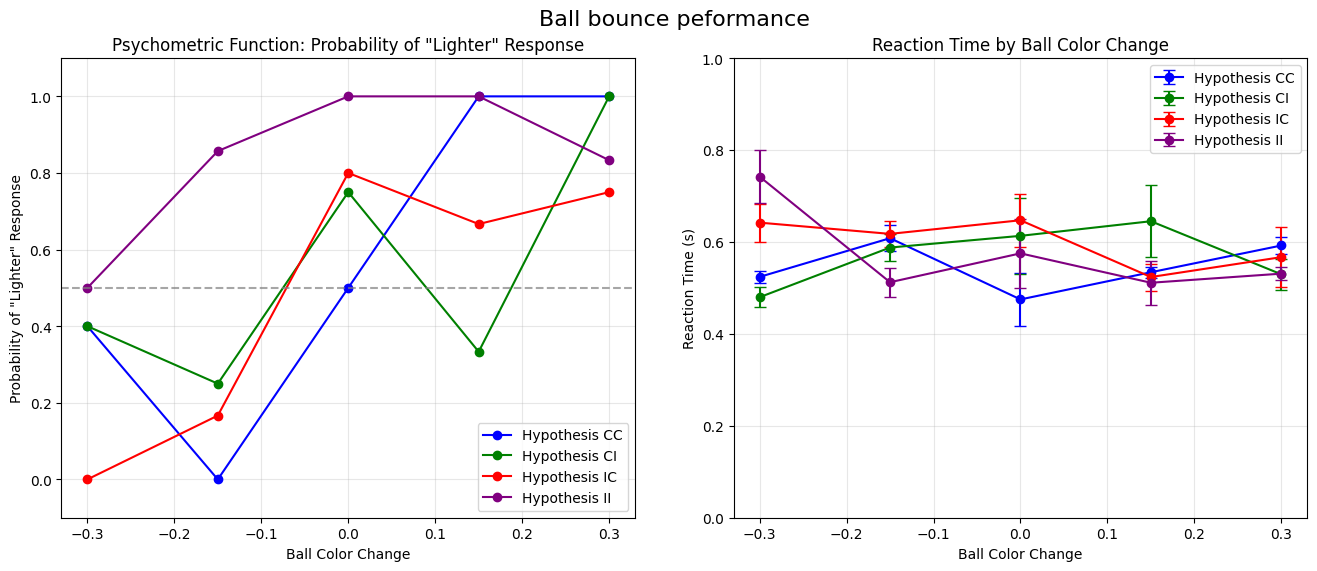

In [73]:

testdf = get_data(subject=None, task="ball_hue")
# testdf = get_data(subject="sub-927320", task="ball_hue")
_ = create_psychometric_plots(data=testdf, 
                              title="Ball bounce peformance", 
                              prob_ylim=(-.1, 1.1), 
                              rt_ylim=(0, 1), 
                              prob_poly_fit=None, 
                              rt_poly_fit=None,
                              split_hypotheses=True)

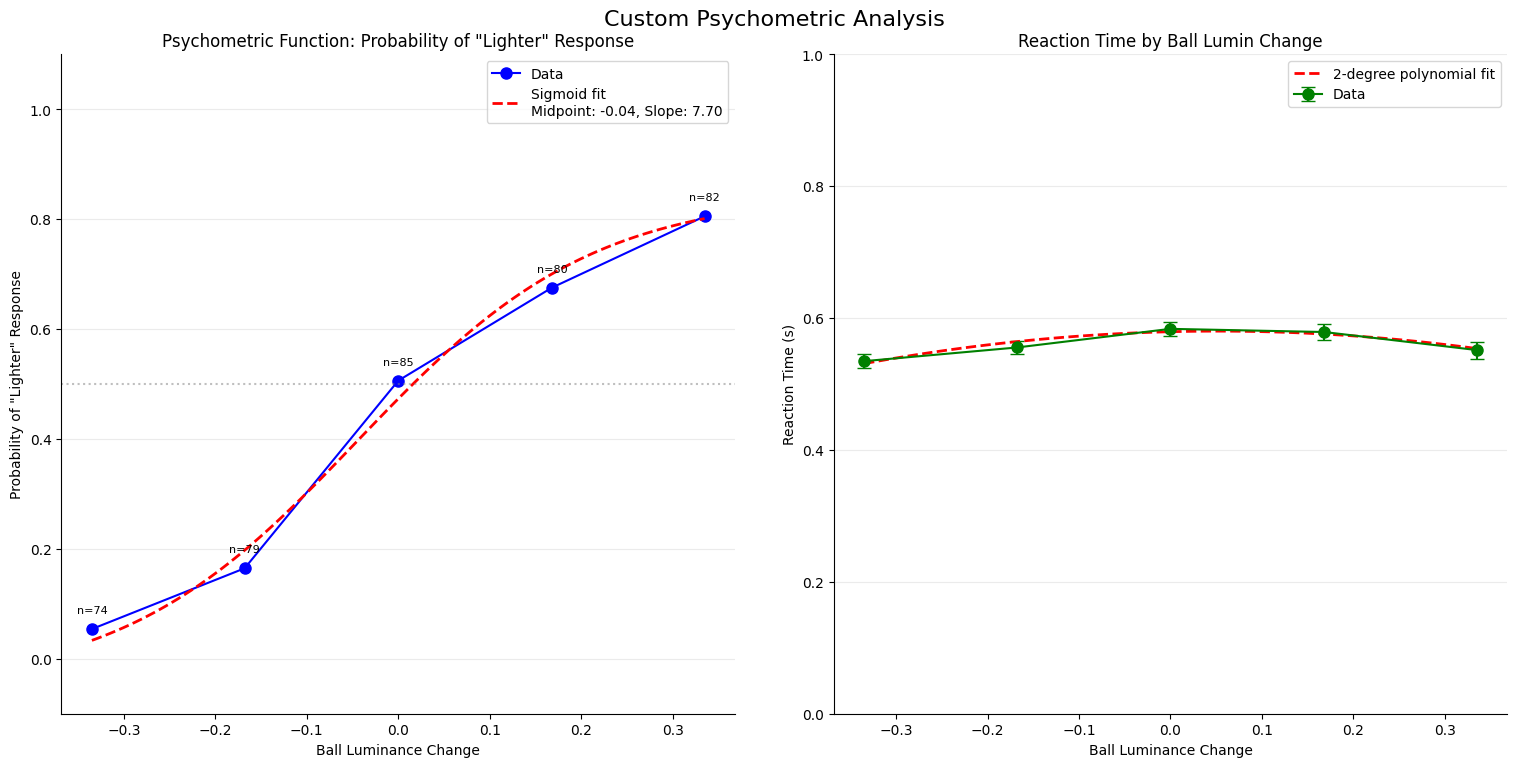

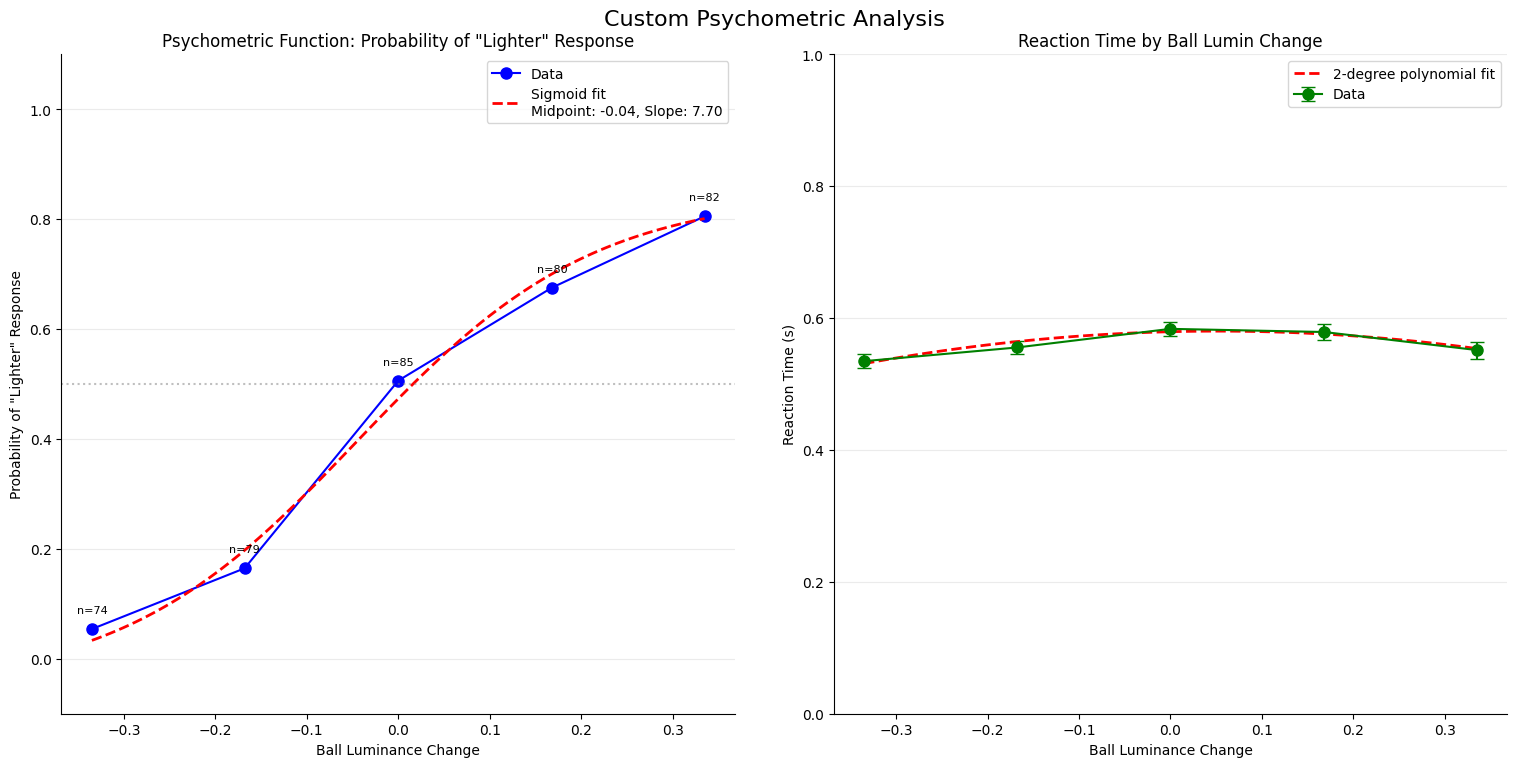

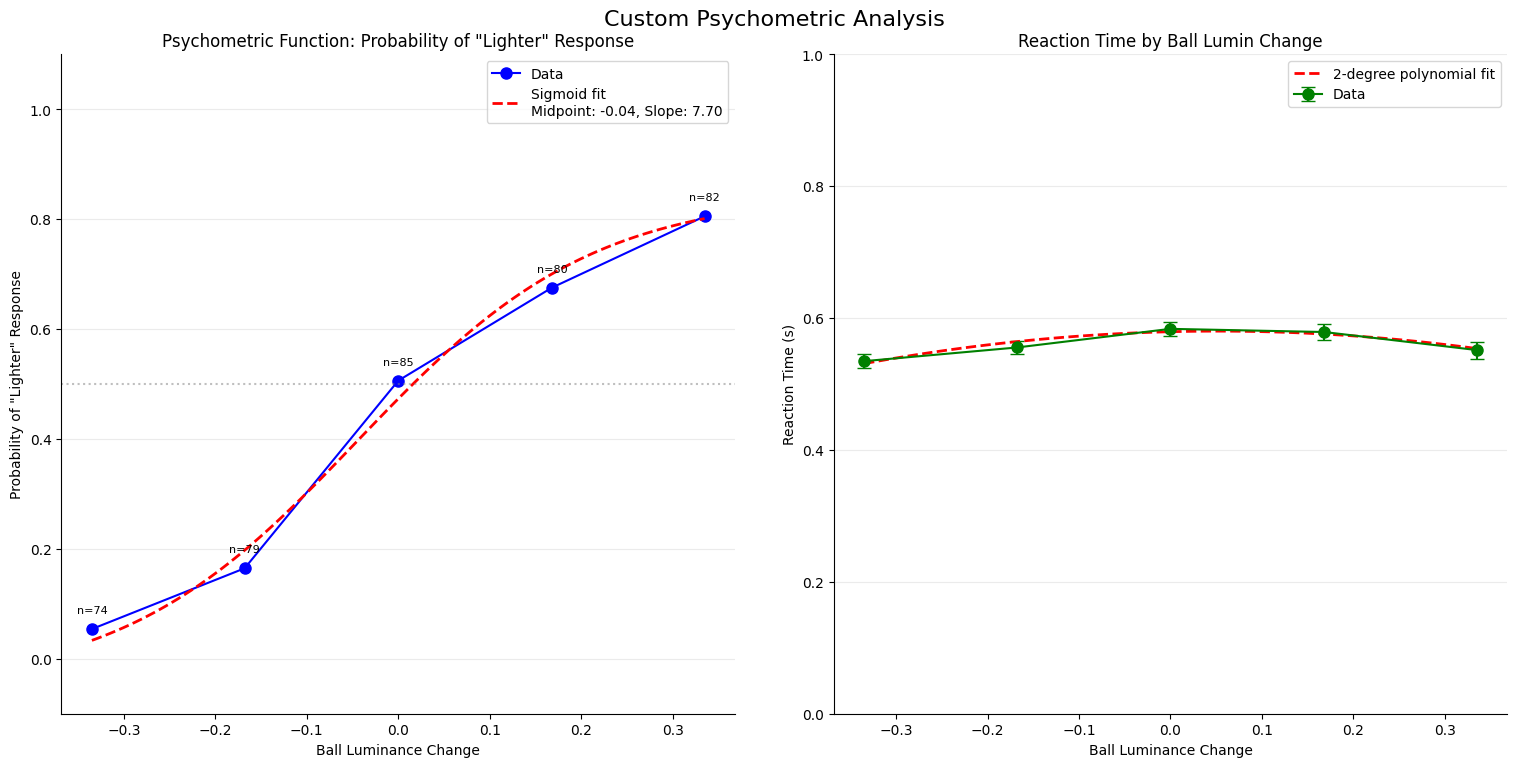

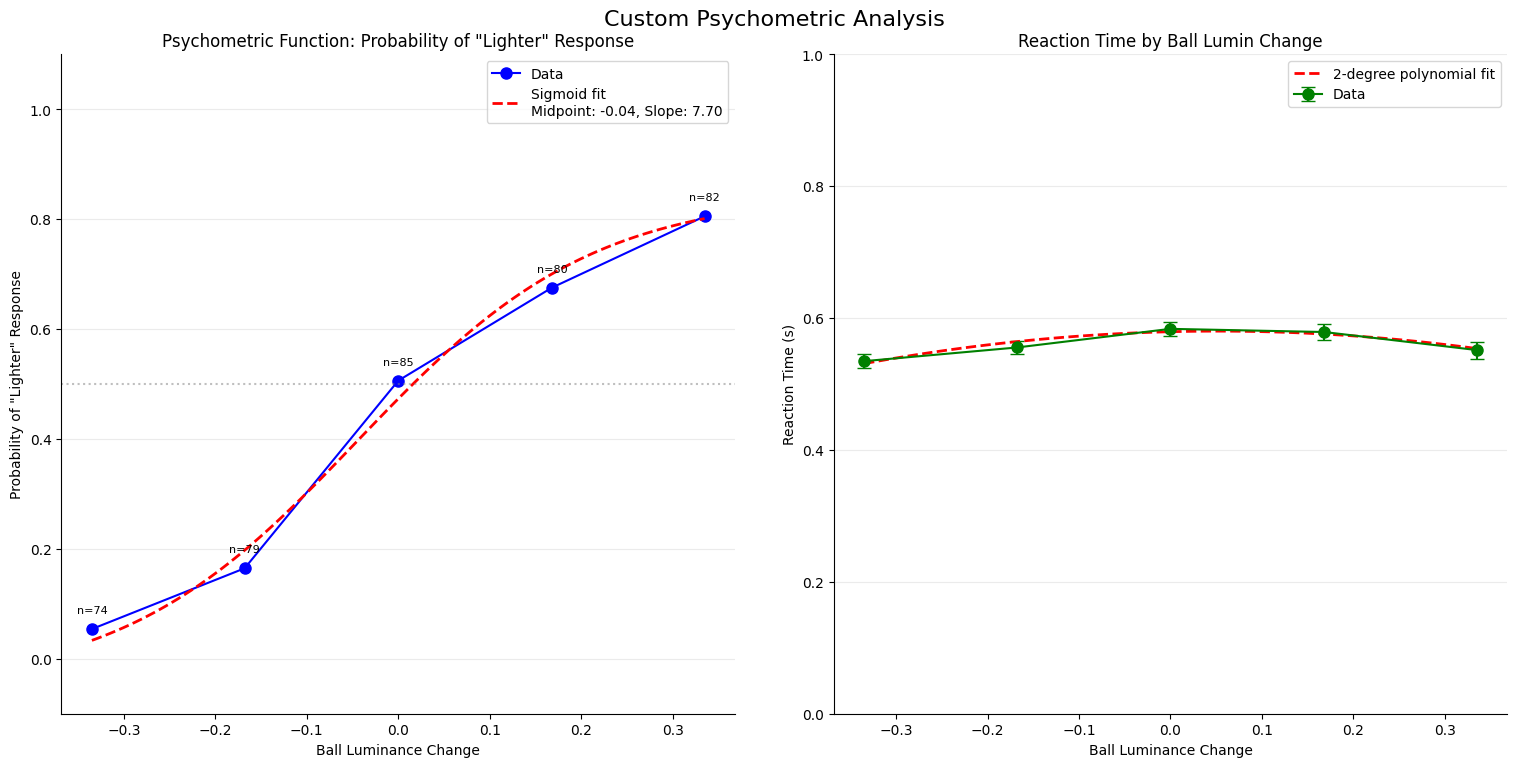

In [578]:

cc = filter_condition(testdf, True, True)
ci = filter_condition(testdf, True, False)
ic = filter_condition(testdf, False, True)
ii = filter_condition(testdf, False, False)

for df in [cc, ci, ic, ii]:
    _ = create_psychometric_plots(data=testdf, 
                                  title="Custom Psychometric Analysis", 
                                  prob_ylim=(-.1, 1.1), 
                                  rt_ylim=(0, 1), 
                                  prob_poly_fit=2, 
                                  rt_poly_fit=2)

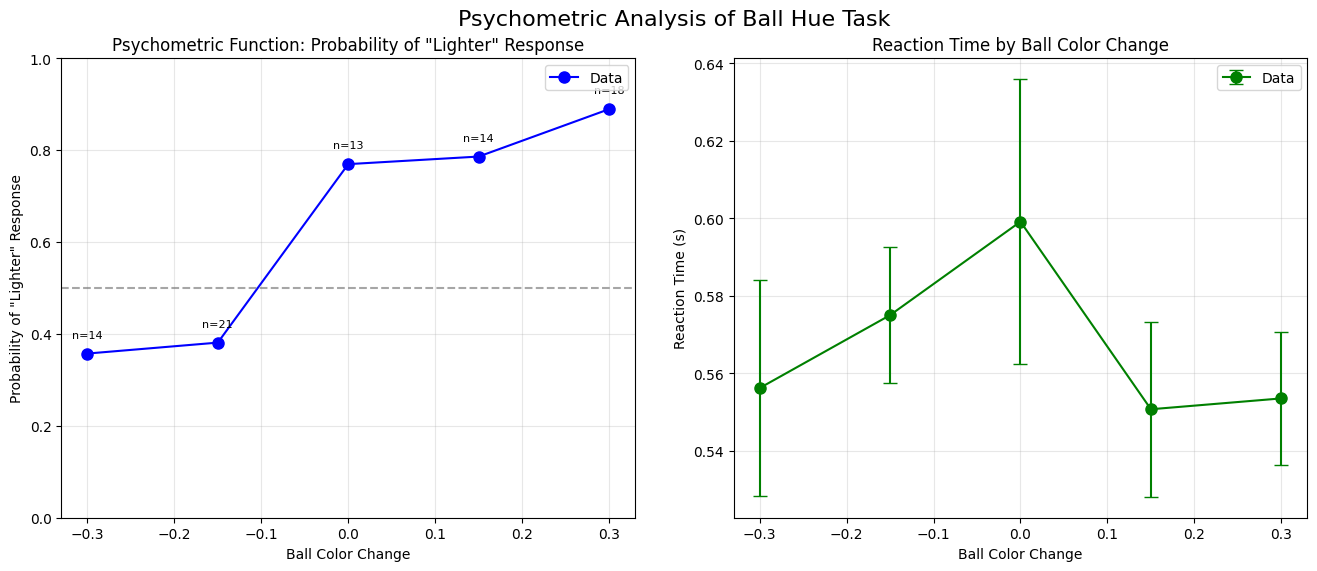

In [78]:
# Example usage:
# create_psychometric_plots(testdf)

# If you want to call this directly with your existing dataframe:
# If your dataframe is called 'testdf' and was loaded with:
# Then just call:



_ = create_psychometric_plots(testdf)

In [9]:
print(sub_stack['response'].unique())
estimator=lambda x: x.mean()
estimator=lambda x: (x.str.lower().str.strip() == 'lighter').mean()


['lighter' 'darker' 'space']


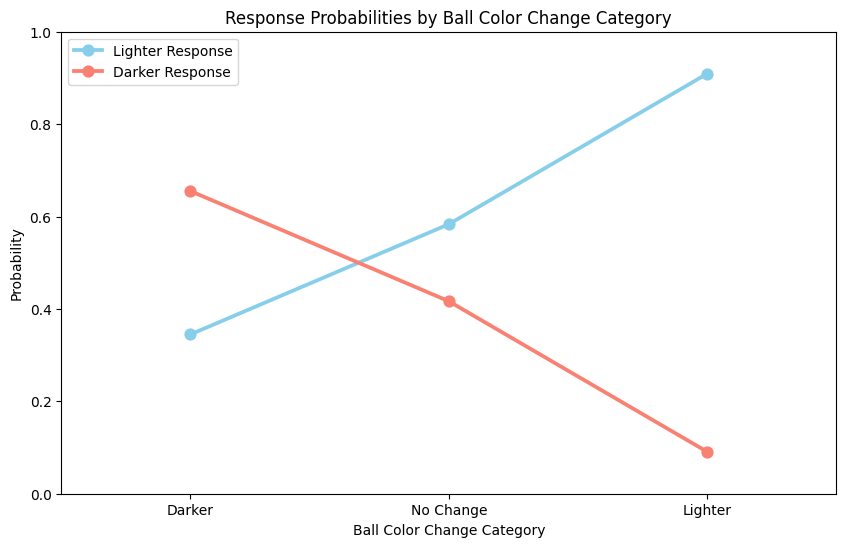

  change_category  lighter_prob  darker_prob
0          Darker      0.344828     0.655172
2       No Change      0.583333     0.416667
1         Lighter      0.909091     0.090909


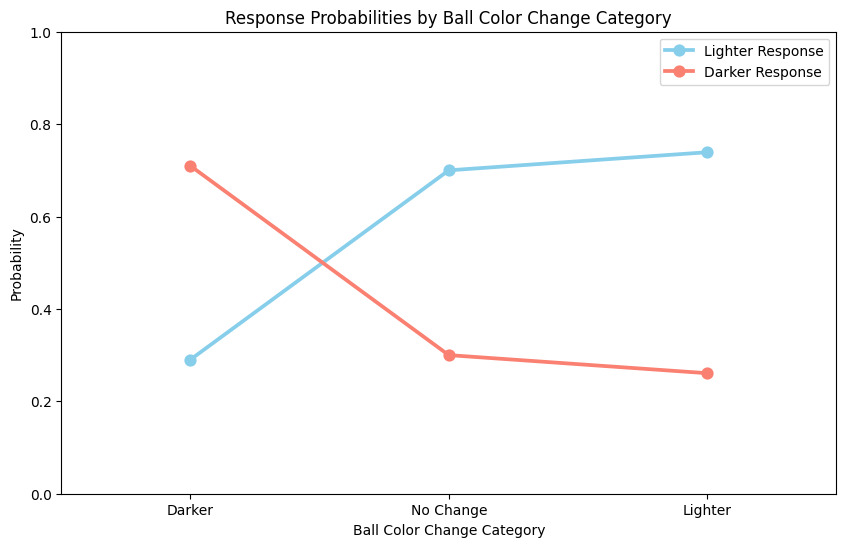

  change_category  lighter_prob  darker_prob
0          Darker      0.290323     0.709677
2       No Change      0.700000     0.300000
1         Lighter      0.739130     0.260870


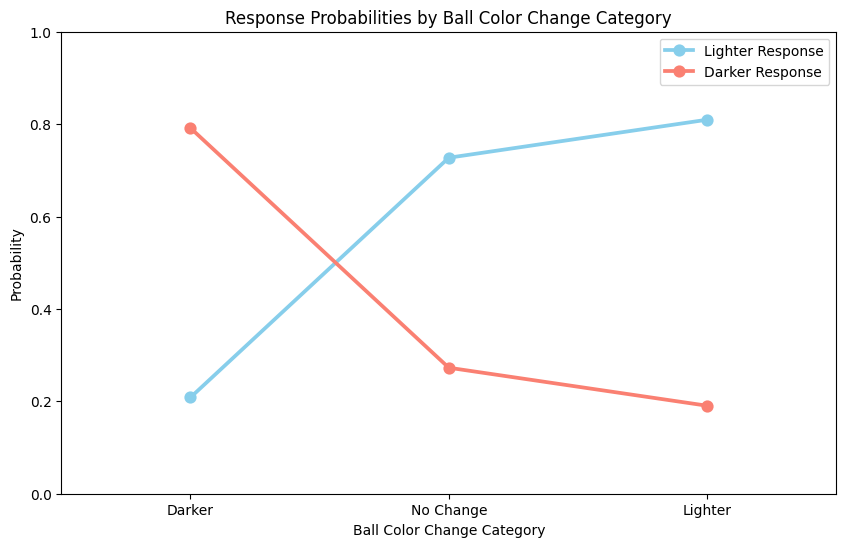

  change_category  lighter_prob  darker_prob
0          Darker      0.208333     0.791667
2       No Change      0.727273     0.272727
1         Lighter      0.809524     0.190476


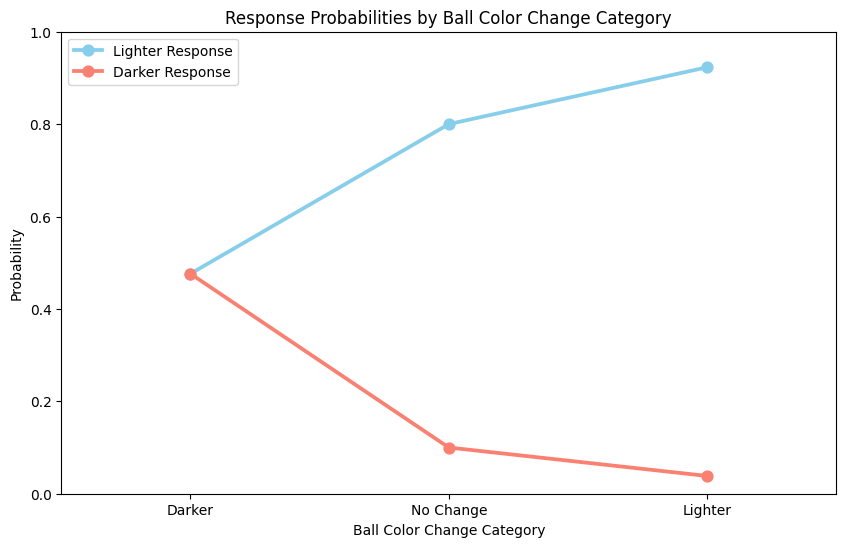

  change_category  lighter_prob  darker_prob
0          Darker      0.476190     0.476190
2       No Change      0.800000     0.100000
1         Lighter      0.923077     0.038462


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
def simple_probplot(data):
    # First, let's create a function to categorize the ball_color_change values
    def categorize_change(value):
        if value < 0:
            return "Darker"
        elif value > 0:
            return "Lighter"
        else:
            return "No Change"

    # Apply this categorization to our data
    data['change_category'] = data['ball_color_change'].apply(categorize_change)

    # Filter out NaN responses
    filtered_data = data.dropna(subset=['response'])

    # Calculate probabilities
    prob_df = filtered_data.groupby('change_category')['response'].agg(
        lighter_prob = lambda x: np.mean(x == "lighter"),
        darker_prob = lambda x: np.mean(x == "darker")
    ).reset_index()

    # Sort the categories in a logical order
    category_order = ["Darker", "No Change", "Lighter"]
    prob_df['change_category'] = pd.Categorical(prob_df['change_category'], categories=category_order, ordered=True)
    prob_df = prob_df.sort_values('change_category')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.pointplot(
        x='change_category',
        y='lighter_prob',
        data=prob_df,
        color='skyblue',
        label='Lighter Response'
    )
    sns.pointplot(
        x='change_category',
        y='darker_prob',
        data=prob_df,
        color='salmon',
        label='Darker Response'
    )
    plt.title('Response Probabilities by Ball Color Change Category')
    plt.xlabel('Ball Color Change Category')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    # Print the probability dataframe for reference
    print(prob_df)


cc = filter_condition(testdf, True, True)
ci = filter_condition(testdf, True, False)
ic = filter_condition(testdf, False, True)
ii = filter_condition(testdf, False, False)

for df in [cc, ci, ic, ii]:
    simple_probplot(df)

/var/folders/3n/yy1xjnlj5zd3nt4r1202183h0000gn/T/ipykernel_32284/1497705146.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='ball_color_change', y='response', data=testdf,
/var/folders/3n/yy1xjnlj5zd3nt4r1202183h0000gn/T/ipykernel_32284/1497705146.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='ball_color_change', y='response', data=testdf,


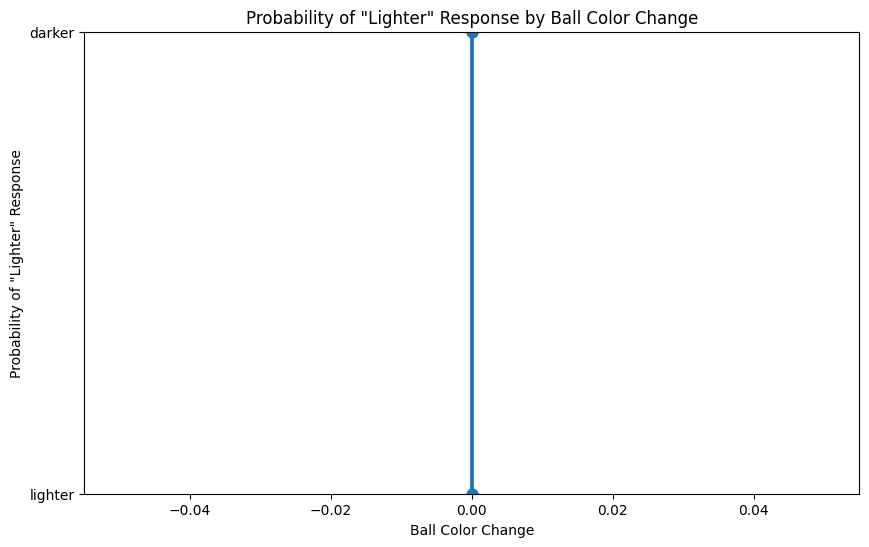

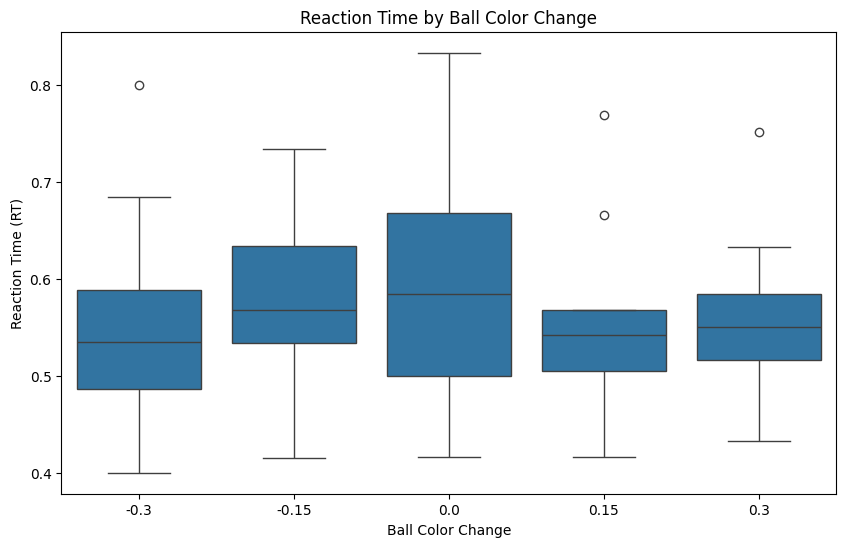

In [54]:
# Plot psychometric curve of the chance

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming testdf is already loaded with your data

# Plot 1: Probability of "lighter" response
plt.figure(figsize=(10, 6))
sns.pointplot(x='ball_color_change', y='response', data=testdf, 
              estimator=lambda x: (x == 'darker').mean(),
              ci=95, join=True)
plt.title('Probability of "Lighter" Response by Ball Color Change')
plt.xlabel('Ball Color Change')
plt.ylabel('Probability of "Lighter" Response')
plt.ylim(0, 1)
plt.show()

# Plot 2: Reaction Time by Ball Color Change
plt.figure(figsize=(10, 6))
sns.boxplot(x='ball_color_change', y='rt', data=testdf)
plt.title('Reaction Time by Ball Color Change')
plt.xlabel('Ball Color Change')
plt.ylabel('Reaction Time (RT)')
plt.show()
